In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage

In [11]:
load_dotenv()

gen_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
eva_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
opt_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [12]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [14]:
struc_eva_llm = eva_llm.with_structured_output(TweetEvaluation)

In [5]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved","needs_improvement"]
    feedback: str
    iteration: int 
    max_iter: int 


In [4]:
def gen_tweet(state: TweetState):

    message = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    response = gen_llm.invoke(message).content
    return {"tweet": response}

In [15]:
def eva_tweet(state: TweetState):

    message = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality - Is this fresh, or have you seen it a hundred times before?  
    2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness - Is it short, sharp, and scroll-stopping?  
    4. Virality Potential - Would people retweet or share it?  
    5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]

    response = struc_eva_llm.invoke(message)

    return {"evaluation":response.evaluation, "feedback":response.feedback}

    

In [16]:
def opt_tweet(state: TweetState):

    message = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
        ]

    response = opt_llm.invoke(message).content
    iteration = state["iteration"]+1
    return {'tweet': response, 'iteration': iteration}

In [19]:
def route(state: TweetState):
    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iter"]:
        return "approved"
    else:
        return "needs_improvement"

In [24]:
graph = StateGraph(TweetState)

graph.add_node("gen_tweet",gen_tweet)
graph.add_node("eva_tweet",eva_tweet)
graph.add_node("opt_tweet",opt_tweet)

graph.add_edge(START,"gen_tweet")
graph.add_edge("gen_tweet","eva_tweet")
graph.add_conditional_edges("eva_tweet", route, {"approved":END, "needs_improvement": "opt_tweet"})

graph.add_edge("opt_tweet","eva_tweet")

workflow = graph.compile()

In [26]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iter": 5
}
result = workflow.invoke(initial_state)

In [27]:
result

{'topic': 'srhberhb',
 'tweet': 'Just accidentally typed "srhberhb" instead of "shredded cheese" and now I\'m pretty sure I\'ve summoned a demon. Worth it for the late-night quesadilla, tbh.',
 'evaluation': 'approved',
 'feedback': "This tweet is a solid mix of humor and relatability. The accidental demon summoning is a funny, unexpected twist on a common late-night craving. It's concise and well within the character limit, making it easily digestible. The 'worth it' punchline lands well, adding to the humor. The tweet has decent virality potential because many people can relate to late-night food cravings and keyboard mishaps, and the demon summoning adds a unique element. It's an original take on a common theme, making it stand out.",
 'iteration': 1,
 'max_iter': 5}

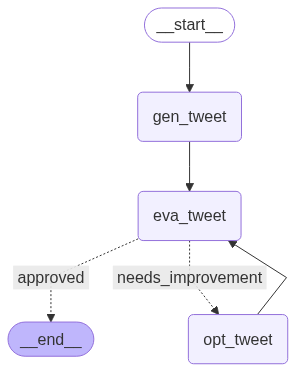

In [28]:
workflow